## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model, Sequential, model_from_json
from keras.layers import Flatten, Dense, Dropout
from keras.activations import sigmoid
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, average_precision_score

## Do some early processing of your metadata for easier model training:

In [26]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
10763,00002793_005.png,No Finding,5,2793,55,F,PA,2430,2961,0.143,0.143,NaN,/data/images_002/images/00002793_005.png
41093,00010641_000.png,No Finding,0,10641,42,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010641_000.png
58694,00014526_001.png,No Finding,1,14526,79,M,PA,2826,2991,0.143,0.143,NaN,/data/images_007/images/00014526_001.png


In [27]:
## Remove rows with unreal ages.
print(len(all_xray_df))
all_xray_df = all_xray_df[(all_xray_df['Patient Age']>0) & (all_xray_df['Patient Age']<100)]
print(len(all_xray_df), max(all_xray_df['Patient Age']), min(all_xray_df['Patient Age']))

112120
112104 95 1


In [28]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = list(set(chain.from_iterable([x.split('|') for x in all_xray_df['Finding Labels']])))
all_labels

['Cardiomegaly',
 'Infiltration',
 'Edema',
 'Pleural_Thickening',
 'Nodule',
 'Pneumothorax',
 'Atelectasis',
 'Hernia',
 'No Finding',
 'Consolidation',
 'Mass',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Pneumonia']

In [29]:
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if label in x else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumothorax,Atelectasis,Hernia,No Finding,Consolidation,Mass,Effusion,Emphysema,Fibrosis,Pneumonia
55700,00013935_002.png,No Finding,2,13935,33,F,PA,2686,2541,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
102473,00027302_002.png,Atelectasis|Infiltration|Mass,2,27302,22,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
97567,00025754_003.png,Consolidation,3,25754,67,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
all_xray_df['Patient Gender'].value_counts(normalize=True)

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

In [31]:
sum(all_xray_df['Pneumonia']==1.0)

1430

In [32]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
# all_xray_df['Pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 1.0 if x == 1.0 else 0.0)
## I already have a "Pneumonia" column for images with or without pneumonia.

## Create your training and testing data:

In [33]:
def create_splits(data,
                  features=None,
                  train_size=0.8,
                  random_state=42,
                  shuffle=True):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(data,
                                            train_size=train_size,
                                            random_state=random_state,
                                            shuffle=shuffle,
                                            stratify=features)
    return train_data, val_data

In [34]:
cols = ['path', 'Pneumonia', 'Patient Gender', 'Patient Age', 'View Position']
simple_xray_df = all_xray_df[cols]
simple_xray_df.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
74173,/data/images_008/images/00018233_041.png,0.0,F,47,AP
93508,/data/images_010/images/00023435_000.png,0.0,M,51,PA
100313,/data/images_011/images/00026577_000.png,0.0,M,35,PA


In [35]:
train_data, val_data = create_splits(simple_xray_df, all_xray_df['Pneumonia'])
len(train_data), len(val_data)

(89683, 22421)

In [36]:
train_data.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
55653,/data/images_007/images/00013922_022.png,0.0,M,53,AP
58221,/data/images_007/images/00014398_010.png,0.0,F,56,AP
92554,/data/images_010/images/00023101_001.png,0.0,M,41,PA


In [37]:
val_data.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
63920,/data/images_007/images/00015770_037.png,0.0,F,66,AP
30560,/data/images_004/images/00007985_000.png,0.0,F,2,AP
103024,/data/images_011/images/00027464_009.png,0.0,F,34,AP


In [38]:
## Make sure the appearance probability is equal in training and validation dataset.
assert round(sum(train_data['Pneumonia']==1.0)/len(train_data), 4) == round(sum(val_data['Pneumonia']==1.0)/len(val_data), 4), "Appearance probabilities in training dataset and validation dataset are different"

In [39]:
sum(train_data['Pneumonia']==1.0)/len(train_data), sum(val_data['Pneumonia']==1.0)/len(val_data)

(0.012756040721206917, 0.01275589848802462)

In [40]:
## Because the probability of Pneumonia in raw dataset is not 50%. So we need to handle this unbalanced datasets.
p_idx = train_data[train_data['Pneumonia']==1.0].index.tolist()
np_idx = train_data[train_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx))
train_data_50 = train_data.loc[p_idx + np_sample]
len(train_data_50), (sum(train_data_50['Pneumonia']==1.0)/len(train_data_50))

(2288, 0.5)

In [41]:
p_idx = val_data[val_data['Pneumonia']==1.0].index.tolist()
np_idx = val_data[val_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx)*4)
val_data_20 = val_data.loc[p_idx + np_sample]
len(val_data_20), (sum(val_data_20['Pneumonia'])/len(val_data_20))

(1430, 0.2)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [42]:
def my_image_augmentation(rotation_range=0.0,
                          width_shift_range=0.0,
                          height_shift_range=0.0,
                          shear_range=0.0,
                          zoom_range=0.0,
                          horizontal_flip=False,
                          vertical_flip=False,
                          validation_split=0.0,
                          rescale=1./255.0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rotation_range=rotation_range,
                                width_shift_range=width_shift_range,
                                height_shift_range=height_shift_range,
                                shear_range=shear_range,
                                zoom_range=zoom_range,
                                horizontal_flip=horizontal_flip,
                                vertical_flip=vertical_flip,
                                validation_split=validation_split,
                                rescale=rescale)
    return my_idg


def make_train_gen(my_train_idg,
                   train_df,
                   x_col,
                   y_col,
                   class_mode='binary',
                   target_size=(224, 224),
                   batch_size=22):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
                                                 directory=None,
                                                 x_col=x_col,
                                                 y_col=y_col,
                                                 class_mode=class_mode,
                                                 target_size=target_size,
                                                 batch_size=batch_size)
    return train_gen


def make_val_gen(my_val_idg,
                 val_df,
                 x_col,
                 y_col,
                 class_mode='binary',
                 target_size=(224, 224),
                 batch_size=22):
    # Todo
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col=x_col,
                                             y_col=y_col,
                                             class_mode=class_mode,
                                             target_size=target_size, 
                                             batch_size=batch_size) 
    return val_gen

In [43]:
my_train_idg=my_image_augmentation(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15)
my_val_idg=my_image_augmentation()

In [44]:
train_data_50['Pneumonia']=train_data_50['Pneumonia'].astype('str')
train_gen=make_train_gen(my_train_idg=my_train_idg,
                         train_df=train_data_50,
                         x_col='path',
                         y_col='Pneumonia')
val_data_20['Pneumonia']=val_data_20['Pneumonia'].astype('str')
val_gen=make_val_gen(my_val_idg=my_val_idg,
                     val_df=val_data_20,
                     x_col='path',
                     y_col='Pneumonia')

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [45]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [46]:
valY

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.], dtype=float32)

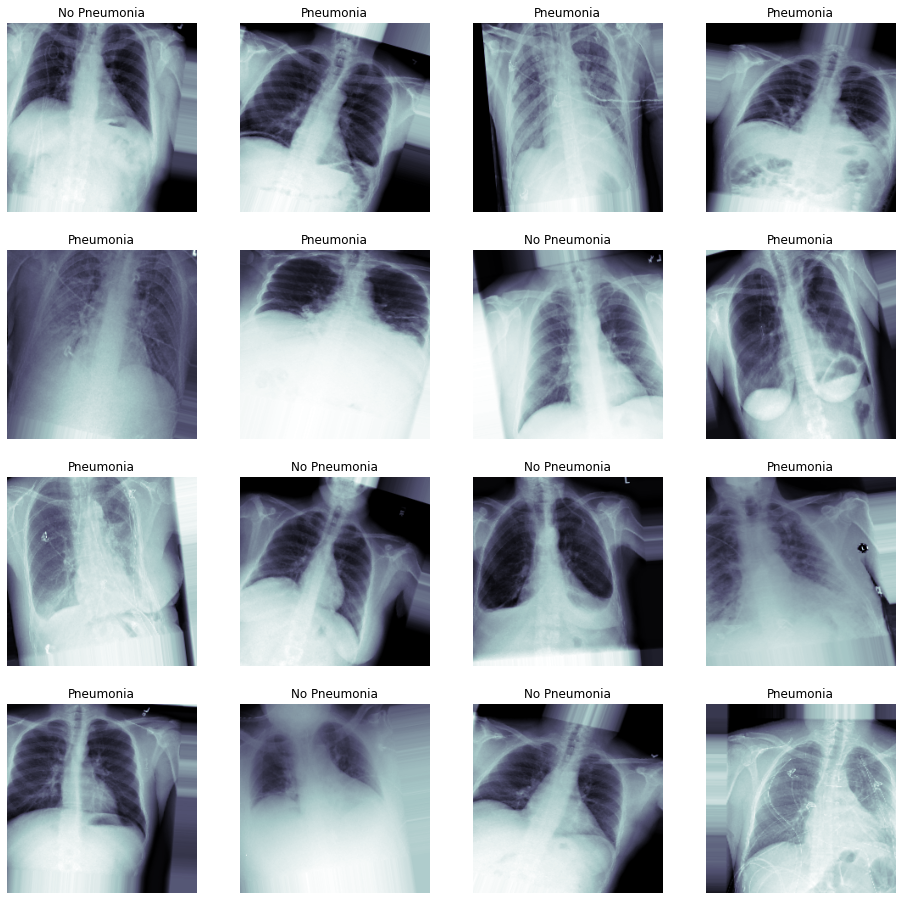

In [47]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [48]:
VGG16(include_top=True, weights='imagenet').summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [49]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model=VGG16(include_top=True, weights='imagenet')
    transfer_layer=model.get_layer('block5_pool')
    vgg_model=Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False
    return vgg_model


In [50]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model=load_pretrained_model()
    my_model=Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [51]:
model_50 = build_my_model()
model_50.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.001),
                 metrics=['binary_accuracy'])
model_50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [52]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class_50')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [53]:
## train your model

# Todo

history = model_50.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
104/104 [==============================] - 67s 642ms/step - loss: 0.7909 - binary_accuracy: 0.5009 - val_loss: 0.7151 - val_binary_accuracy: 0.2273

Epoch 00001: val_loss improved from inf to 0.71514, saving model to xray_class_50_my_model.best.hdf5
Epoch 2/20
104/104 [==============================] - 64s 619ms/step - loss: 0.6956 - binary_accuracy: 0.5127 - val_loss: 0.7234 - val_binary_accuracy: 0.2273

Epoch 00002: val_loss did not improve from 0.71514
Epoch 3/20
104/104 [==============================] - 60s 580ms/step - loss: 0.6937 - binary_accuracy: 0.5271 - val_loss: 0.6601 - val_binary_accuracy: 0.7727

Epoch 00003: val_loss improved from 0.71514 to 0.66011, saving model to xray_class_50_my_model.best.hdf5
Epoch 4/20
104/104 [==============================] - 60s 576ms/step - loss: 0.6933 - binary_accuracy: 0.5350 - val_loss: 0.6476 - val_binary_accuracy: 0.8182

Epoch 00004: val_loss improved from 0.66011 to 0.64761, saving model to xray_class_50_my_model.best.hdf

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [54]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path='xray_class_50_my_model.best.hdf5'
model_50.load_weights(weight_path)
pred_Y = model_50.predict(valX, batch_size = 32, verbose = True)


22/22 [==============================] - 0s 16ms/step


In [55]:
pred_Y_binary = [1 if i[0] > 0.5 else 0 for i in pred_Y]

In [56]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history, kind):
    '''
    kind: either "accuracy" or "loss"
    '''
    plt.figure(figsize = (9, 9))
    kind = 'binary_accuracy' if kind == 'accuracy' else kind
    plt.plot(history.history[f'val_{kind}'], label=f'validation {kind}')
    plt.plot(history.history[f'{kind}'], label=f'training {kind}')
    plt.title(f'Validation/Training {kind}')
    plt.ylabel('EPOCHS')
    plt.legend()
    plt.show()
    
    return


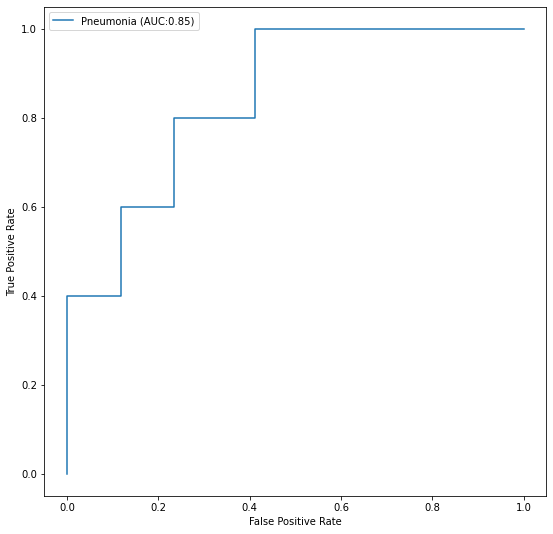

In [57]:
## plot figures

# Todo
plot_auc(valY, pred_Y)

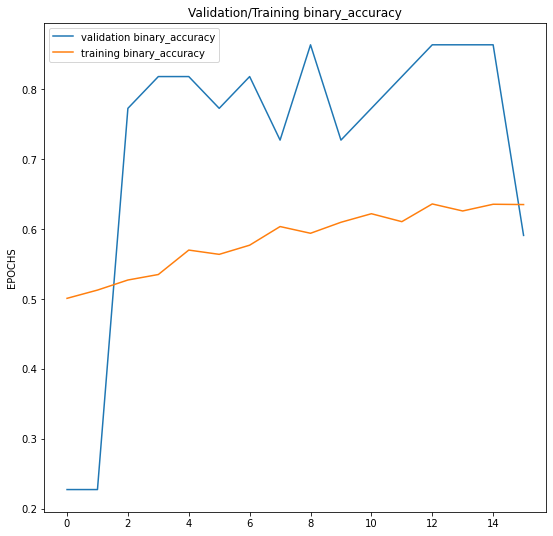

In [58]:
plot_history(history, 'accuracy')

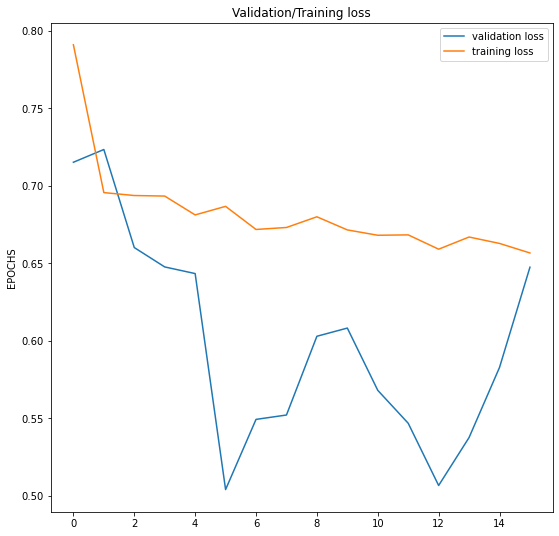

In [59]:
plot_history(history, 'loss')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [60]:
confusion_matrix(pred_Y_binary, valY)

array([[14,  2],
       [ 3,  3]])

In [61]:
pred_Y, max(pred_Y), min(pred_Y)

(array([[0.47710782],
        [0.18581378],
        [0.56846243],
        [0.53053933],
        [0.1645048 ],
        [0.57136166],
        [0.3453153 ],
        [0.20367154],
        [0.28895083],
        [0.55509514],
        [0.51707304],
        [0.47489372],
        [0.29742286],
        [0.20349033],
        [0.34954414],
        [0.5032947 ],
        [0.27564645],
        [0.24893336],
        [0.36039641],
        [0.36245996],
        [0.44939724],
        [0.4406426 ]], dtype=float32),
 array([0.57136166], dtype=float32),
 array([0.1645048], dtype=float32))

In [62]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    pred_Y_custom = [1 if pred>t else 0 for pred in pred_Y]
    print(confusion_matrix(pred_Y_custom, valY))
    tn, fp, fn, tp = confusion_matrix(pred_Y_custom, valY).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    print("Precision: "+str(precision))
    print("recall: "+str(recall))
    print("Specificity: "+str(tn/(tn+fp)))
    print("F1: "+str(2*(precision*recall)/(precision+recall)))
    print("-------------------------------------")

[[8 0]
 [9 5]]
Precision: 1.0
recall: 0.35714285714285715
Specificity: 1.0
F1: 0.5263157894736842
-------------------------------------
[[11  1]
 [ 6  4]]
Precision: 0.8
recall: 0.4
Specificity: 0.9166666666666666
F1: 0.5333333333333333
-------------------------------------
[[14  2]
 [ 3  3]]
Precision: 0.6
recall: 0.5
Specificity: 0.875
F1: 0.5454545454545454
-------------------------------------
[[17  5]
 [ 0  0]]
Precision: 0.0
recall: nan
Specificity: 0.7727272727272727
F1: nan
-------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [63]:
# json_file = open('my_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("xray_class_50_my_model.best.hdf5")
# print("Loaded model from disk")
# pred_Y = loaded_model.predict(valX, batch_size = 32, verbose = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


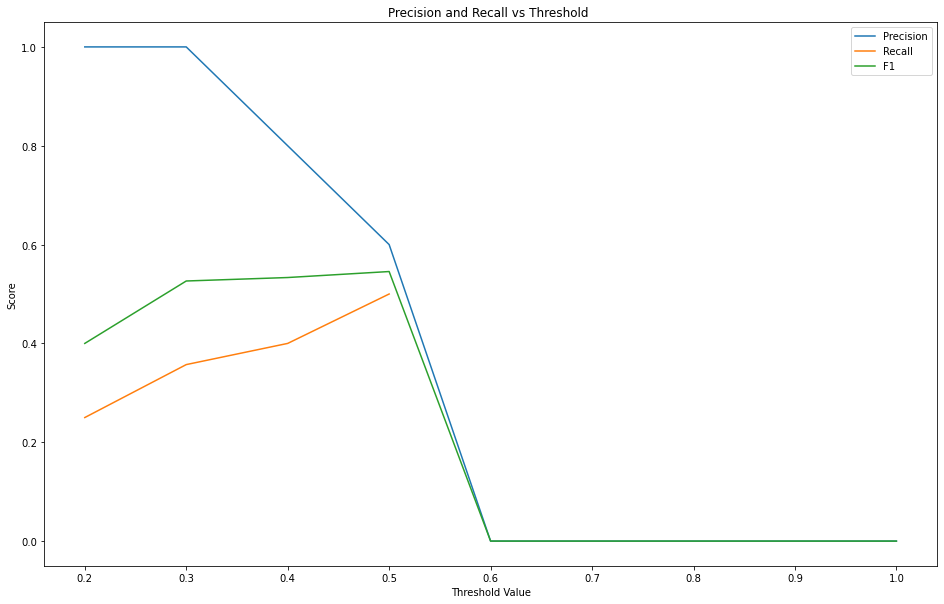

In [64]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
prec = []
recall = []
fscore = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    tn, fp, fn, tp = confusion_matrix(pred_Y_binary, valY).ravel()
    prec.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    fscore.append(f1_score(valY, pred_Y_binary))

plt.figure(figsize=(16,10))
plt.plot(thresholds, prec, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, fscore, label='F1')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold ')
plt.legend()
plt.show()

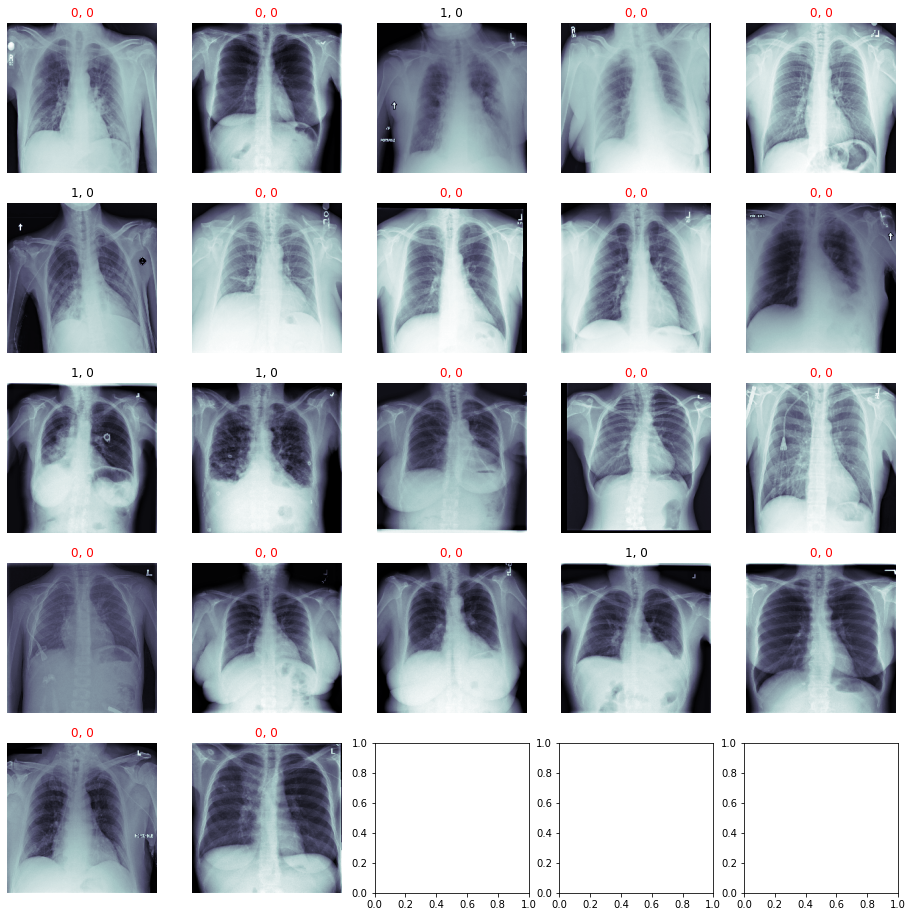

In [65]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.6:
            c_ax.set_title('1, 1', color='r')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.6: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0', color='r')
    c_ax.axis('off')
    i=i+1

In [66]:
## Just save model architecture to a .json:

model_json = model_50.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# I am little curious that what if I remove some confusion diseases. Maybe i could get better result

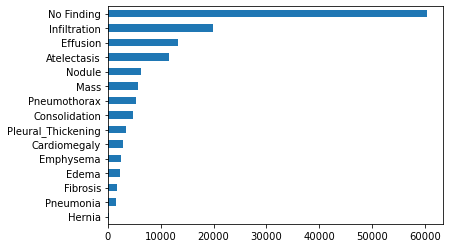

In [123]:
all_xray_df[all_labels].sum().nlargest(15).sort_values().plot(kind='barh')

### Based on the EDA result before, 'Consolidation', 'Infiltration', and 'Mass' are the most three confusion diseases compare to Pneumonia

In [128]:
less_xray_df = all_xray_df[(all_xray_df['Consolidation']!=1) & (all_xray_df['Infiltration']!=1) & (all_xray_df['Mass']!=1)]
less_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumonia,No Finding,Fibrosis,Edema,Mass,Nodule,Infiltration,Pleural_Thickening,Emphysema,Atelectasis
11162,00002895_000.png,Atelectasis|Pleural_Thickening,0,2895,59,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
51049,00012903_000.png,No Finding,0,12903,51,F,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83807,00020595_003.png,No Finding,3,20595,62,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16856,00004526_002.png,Cardiomegaly,2,4526,43,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94156,00023956_000.png,No Finding,0,23956,23,F,PA,2682,2377,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
len(less_xray_df)

84593

In [130]:
less_xray_df['Pneumonia'].sum()

712.0

In [131]:
simple_less_xray_df = less_xray_df[cols]
simple_less_xray_df.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
98088,/data/images_011/images/00025887_000.png,0.0,M,34,PA
6908,/data/images_002/images/00001836_094.png,0.0,F,50,AP
102075,/data/images_011/images/00027189_001.png,0.0,M,60,AP


In [133]:
train_data, val_data = create_splits(simple_less_xray_df, simple_less_xray_df['Pneumonia'])
len(train_data), len(val_data)

(67674, 16919)

In [140]:
p_idx = train_data[train_data['Pneumonia']==1.0].index.tolist()
np_idx = train_data[train_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx))
train_data_50 = train_data.loc[p_idx + np_sample]
len(train_data_50), (sum(train_data_50['Pneumonia']==1.0)/len(train_data_50))

(1140, 0.5)

In [141]:
p_idx = val_data[val_data['Pneumonia']==1.0].index.tolist()
np_idx = val_data[val_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx)*4)
val_data_20 = val_data.loc[p_idx + np_sample]
len(val_data_20), (sum(val_data_20['Pneumonia'])/len(val_data_20))

(710, 0.2)

In [142]:
my_train_idg=my_image_augmentation(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15)
my_val_idg=my_image_augmentation()

In [144]:
train_data_50['Pneumonia']=train_data_50['Pneumonia'].astype('str')
train_gen=make_train_gen(my_train_idg=my_train_idg,
                         train_df=train_data_50,
                         x_col='path',
                         y_col='Pneumonia')
val_data_20['Pneumonia']=val_data_20['Pneumonia'].astype('str')
val_gen=make_val_gen(my_val_idg=my_val_idg,
                     val_df=val_data_20,
                     x_col='path',
                     y_col='Pneumonia')

Found 1140 validated image filenames belonging to 2 classes.
Found 710 validated image filenames belonging to 2 classes.


In [145]:
valX, valY = val_gen.next()

In [146]:
## Since we got less data this turn, I would like to reduce the number of layers
def build_my_model2():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model=load_pretrained_model()
    my_model=Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model

In [147]:
model_50 = build_my_model2()
model_50.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.001),
                 metrics=['binary_accuracy'])
model_50.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [149]:
weight_path="{}_my_model.best.hdf5".format('xray_class_50_less')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [150]:
history = model_50.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
52/52 [==============================] - 31s 605ms/step - loss: 0.7122 - binary_accuracy: 0.5140 - val_loss: 0.7007 - val_binary_accuracy: 0.2727

Epoch 00001: val_loss improved from inf to 0.70070, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 2/20
52/52 [==============================] - 30s 572ms/step - loss: 0.6978 - binary_accuracy: 0.4965 - val_loss: 0.6937 - val_binary_accuracy: 0.3636

Epoch 00002: val_loss improved from 0.70070 to 0.69368, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 3/20
52/52 [==============================] - 30s 572ms/step - loss: 0.6949 - binary_accuracy: 0.5193 - val_loss: 0.6829 - val_binary_accuracy: 0.6364

Epoch 00003: val_loss improved from 0.69368 to 0.68285, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 4/20
52/52 [==============================] - 30s 575ms/step - loss: 0.6965 - binary_accuracy: 0.4825 - val_loss: 0.6996 - val_binary_accuracy: 0.3636

Epoch 00004: val_loss did not improve from

In [151]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path='xray_class_50_less_my_model.best.hdf5'
model_50.load_weights(weight_path)
pred_Y = model_50.predict(valX, batch_size = 32, verbose = True)

22/22 [==============================] - 0s 18ms/step


In [152]:
pred_Y_binary = [1 if i[0] > 0.5 else 0 for i in pred_Y]

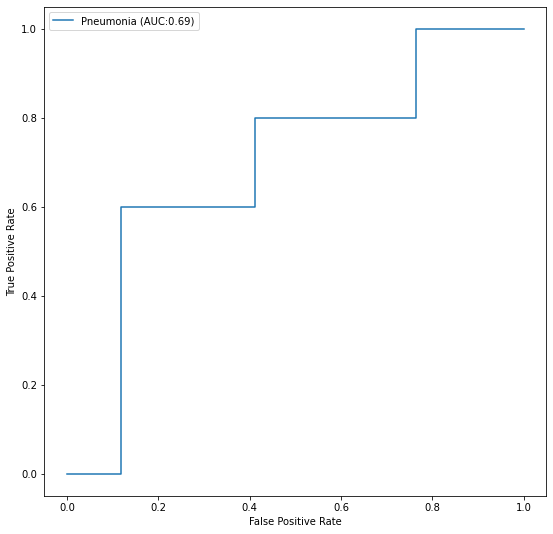

In [153]:
plot_auc(valY, pred_Y)

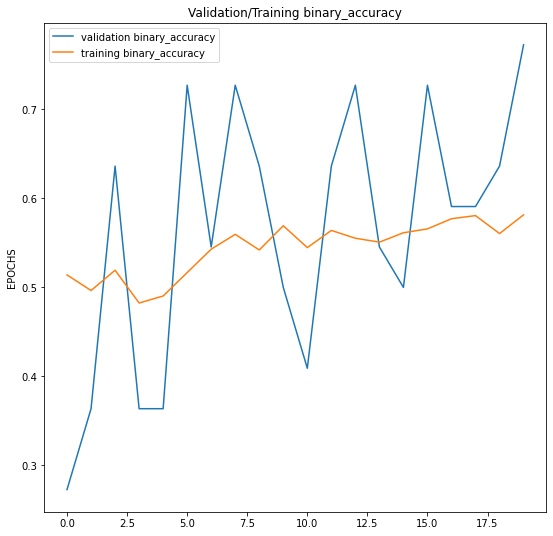

In [154]:
plot_history(history, 'accuracy')

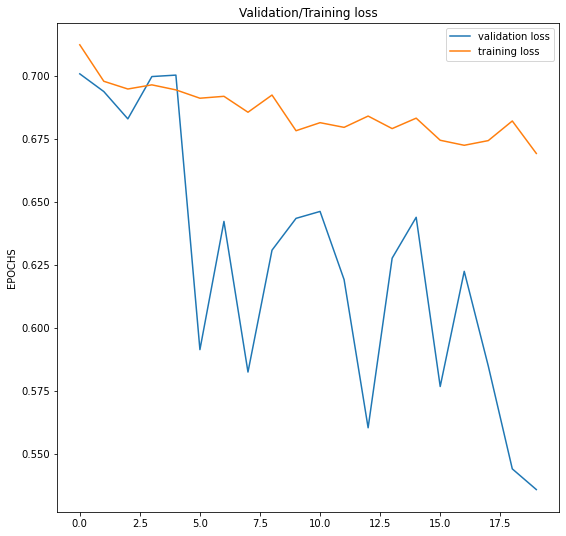

In [155]:
plot_history(history, 'loss')

In [156]:
confusion_matrix(pred_Y_binary, valY)

array([[14,  2],
       [ 3,  3]])

In [157]:
pred_Y, max(pred_Y), min(pred_Y)

(array([[0.08167093],
        [0.4692579 ],
        [0.16173485],
        [0.20939633],
        [0.45606783],
        [0.55615574],
        [0.42004266],
        [0.5122597 ],
        [0.5227879 ],
        [0.45159614],
        [0.27327776],
        [0.43379402],
        [0.07027774],
        [0.00240203],
        [0.52481097],
        [0.34941068],
        [0.15519604],
        [0.54607314],
        [0.03416156],
        [0.1140102 ],
        [0.6546583 ],
        [0.27495036]], dtype=float32),
 array([0.6546583], dtype=float32),
 array([0.00240203], dtype=float32))

In [158]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    pred_Y_custom = [1 if pred>t else 0 for pred in pred_Y]
    print(confusion_matrix(pred_Y_custom, valY))
    tn, fp, fn, tp = confusion_matrix(pred_Y_custom, valY).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    print("Precision: "+str(precision))
    print("recall: "+str(recall))
    print("Specificity: "+str(tn/(tn+fp)))
    print("F1: "+str(2*(precision*recall)/(precision+recall)))
    print("-------------------------------------")

[[ 4  0]
 [13  5]]
Precision: 1.0
recall: 0.2777777777777778
Specificity: 1.0
F1: 0.4347826086956522
-------------------------------------
[[ 6  1]
 [11  4]]
Precision: 0.8
recall: 0.26666666666666666
Specificity: 0.8571428571428571
F1: 0.4
-------------------------------------
[[9 1]
 [8 4]]
Precision: 0.8
recall: 0.3333333333333333
Specificity: 0.9
F1: 0.47058823529411764
-------------------------------------
[[10  1]
 [ 7  4]]
Precision: 0.8
recall: 0.36363636363636365
Specificity: 0.9090909090909091
F1: 0.5000000000000001
-------------------------------------
[[14  2]
 [ 3  3]]
Precision: 0.6
recall: 0.5
Specificity: 0.875
F1: 0.5454545454545454
-------------------------------------
[[16  5]
 [ 1  0]]
Precision: 0.0
recall: 0.0
Specificity: 0.7619047619047619
F1: nan
-------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


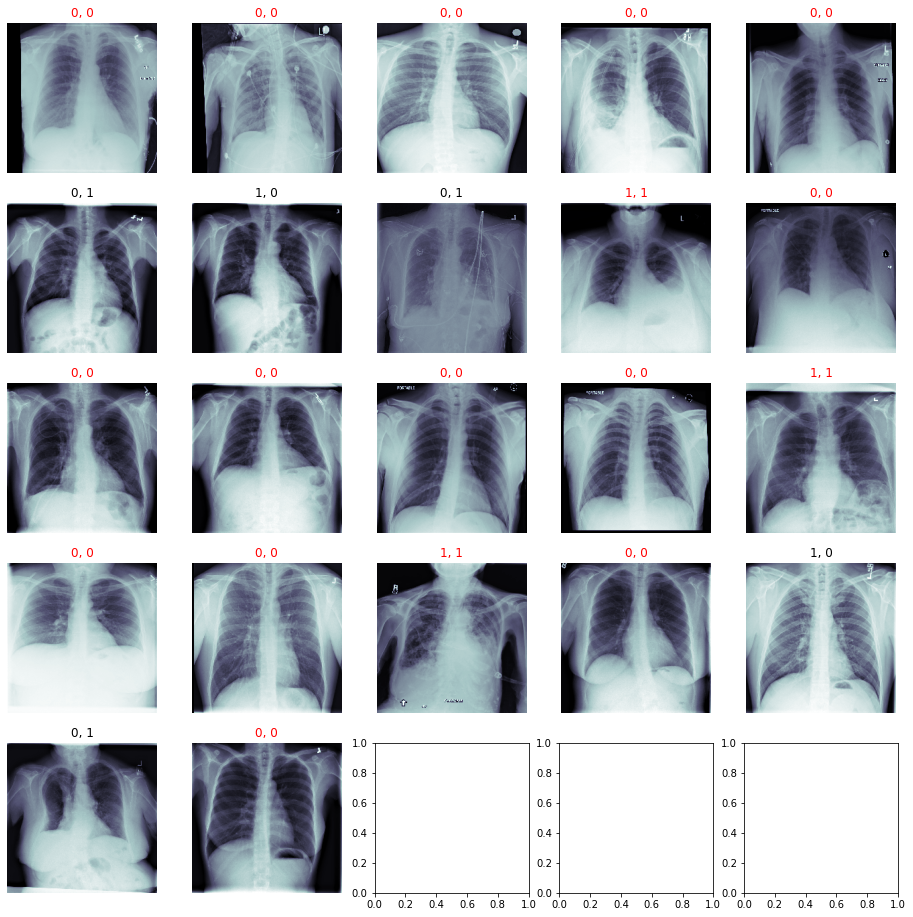

In [159]:
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.5:
            c_ax.set_title('1, 1', color='r')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.5: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0', color='r')
    c_ax.axis('off')
    i=i+1

In [ ]:
## So, unfortunately, the result become worse than previous. I w